In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
from shapely.ops import unary_union
from simplekml import Kml, Style, Color
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
import os
import pandas as pd
from pyproj import Geod
from datetime import timedelta
import xarray as xr
import glob
import dask
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import gzip
import shutil
import folium
import branca
import json

# Generating MESH Scans from MRMS CONUS Grib2 File Example

NOAA MESH (Maximum Estimated Size of Hail) scans are useful for evaluating hail events across different times and locations. It can be used to identify potential hail damaged areas for insurance purposes. NOAA provides public MESH data on [AWS](https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/) (Amazon Web Services) created from their [MRMS (Multi-Radar/Multi-Sensor System)](https://registry.opendata.aws/noaa-mrms-pds/) with data available from 2020 to present day. The files on AWS are saved as zipped GRIB2 format with each filename showing the datetime of the MRMS scan, which covers CONUS (Continental United States). MESH and other weather data from MRMS is also displayed on [NOAA's MRMS Product Viewer](https://mrms.nssl.noaa.gov/qvs/product_viewer/).

Although these MRMS MESH data are publicly available on the Product Viewer and AWS, there is currently no efficient way to read, extract, and process data from these GRIB2 files for further analyses. There's also no efficient way to convert these GRIB2 files into KML or GeoJSON format. KML or GeoJSON files are more compatible with GIS softwares like Google Earth or web mapping packages like Folium, which makes it more ideal in creating digital geospatial visualizations. 

This example will demonstrate the process in reading data from a GRIB2 file and converting it into a KML or GeoJSON format for easier parsing of data. This example specifically uses a MRMS scan for June 22, 2023, which coincided with a hail storm that occurred in the Denver, CO metropolitan area on June 22-23, 2023.

## 1) Locate Storm's Date and NW, SE Coordinates

Get the storm's date.

In [6]:
# Convert date into datetime
storm_dt = pd.to_datetime("6/22/2023")
# String dates for file naming
storm_dt_str = storm_dt.strftime("%Y-%m-%d")

Select a northwest coordinate and southeast coordinate to create a bounding box for the MESH scan. The pulled GRIB2 file gives a MESH scan of the entire U.S., so creating a bounding box let's us crop the scan to specifically look at the location of interest.

In [8]:
# NW and SE coordinates of Denver metropolitian area
northwest_lat, northwest_lon = 40.082964013494525, -105.48325730750766
southeast_lat, southeast_lon = 39.432013043114594, -104.56268931535676

## 2) Download MESH Max 1440 Minute GRIB2 Data from MRMS CONUS AWS 

Download the MRMS CONUS data from AWS from the storm's start and end dates. This example specifically pulls data from the [MESH_Max_1440min_00.50](https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/MESH_Max_1440min_00.50/) folder, which gives the MESH scan within the past 1440 min (24 hrs). For example, MRMS_MESH_Max_1440min_00.50_20230623-000000 is a MESH scan from 2023-06-22 00:00:00 to 2023-06-23 00:00:00. Using the 1440 min data provides quicker results since data are compressed to one day in one file, meaning there are less files to pull and making the process quicker.

In [11]:
# Output folder of where to save grib2 files
grib2_output_folder = os.path.join("panel_segmentation", "examples", "mesh_examples",
                                   "aws_mrms_pull", f"MESH_Max_1440min_00.50_{storm_dt_str}")
# Make output directory with storm's datetime
os.makedirs(grib2_output_folder, exist_ok=True)
# Connect to s3 client with boto3
s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
# Format the s3 bucket and folder path
aws_mrms_bucket = "noaa-mrms-pds"
# Query next day to get the previous 24 hr data
next_day_dt = storm_dt + timedelta(days=1)
prefix = f"CONUS/MESH_Max_1440min_00.50/{next_day_dt:%Y%m%d}"
# List files in bucket and folder path
response = s3_client.list_objects_v2(Bucket=aws_mrms_bucket, Prefix=prefix)
for obj in response.get("Contents", []):
        # Download all the next day midnight files of the current date
        gz_file = obj["Key"].split("/")[-1]
        if "-000000.grib2" in gz_file:
            gz_path = os.path.join(grib2_output_folder, gz_file)
            s3_client.download_file(aws_mrms_bucket, obj["Key"], gz_path)
            # Unzip the file and download it into output folder
            output_path = os.path.join(grib2_output_folder, gz_file.replace(".gz", ""))
            with gzip.open(gz_path, "rb") as file_in:
                with open(output_path, "wb") as file_out:
                    shutil.copyfileobj(file_in, file_out)
            print(f"Downloaded: {output_path}")
            # Remove zipped file
            os.remove(gz_path)

Downloaded: panel_segmentation\examples\mesh_examples\aws_mrms_pull\MESH_Max_1440min_00.50_2023-06-22\MRMS_MESH_Max_1440min_00.50_20230623-000000.grib2


## 3) Process GRIB2 File into Matplotlib Contours

After downloading the GRIB2 files, we will read them using the xarray and cfgrib packages. This will convert the data from the GRIB2 file into a multi-dimensional array. This array structure allows us to slice the data to a bounding box (bbox) created from the NW and SE coordinates. After slicing the array, we can then use matplotlib contours to find the contoured area of each MESH value.

Get a list of all the grib2 files pulled using glob.

In [15]:
grib2_file_list = []
grib2_file_list = glob.glob(os.path.join(grib2_output_folder, "*.grib2"))

Grib2 file is a compressed, binary formatted file that stores multi-dimensional data like latitude, longitude, datetime, and weather data. With xarray and cfgrib, grib2 files can be read and processed in Python as a multi-dimensional array. It should also be noted that the original data uses a longitude range of 0 to 360. However, the longitude range should be converted to a range of -180 to 180 to be compatible with mapping tools like Google Earth.

In [17]:
# Combine multiple grib2 files into one xarray
grib2_dataset = xr.open_mfdataset(
    grib2_file_list, combine="nested", concat_dim="time", engine='cfgrib', decode_timedelta=True)

# MESH data is listed as "unknown" variable name
grib2_mesh = grib2_dataset["unknown"]
# Get latitudeand longitude coordinates values
grib2_lat = grib2_mesh["latitude"].values
# Convert grib2 longitude data from 0-360 range to -180-180 
grib2_lon = ((grib2_mesh["longitude"].values + 180) % 360) - 180

Ignoring index file 'C:\\Users\\qnguyen\\Documents\\GitHub_repos\\Panel-Segmentation\\panel_segmentation\\examples\\mesh_examples\\aws_mrms_pull\\MESH_Max_1440min_00.50_2023-06-22\\MRMS_MESH_Max_1440min_00.50_20230623-000000.grib2.5b7b6.idx' older than GRIB file


After getting the latitude, longitude, and mesh data values, we can crop the scan to be within the bounding box (bbox) created from the NW and SE coordinates. The original MESH unit is in mm, but inches will be used for this example. A filter of 0.3in is also applied to reduce noise in the scans.

In [19]:
bbox_lat = []
bbox_lon = []
# Get latitude and longitude values within requsted lat and long
for coord in grib2_lat:
    if coord <= northwest_lat and coord >= southeast_lat:
        bbox_lat.append(coord)
for coord in grib2_lon:
    if coord >= northwest_lon and coord <= southeast_lon:
        bbox_lon.append(coord)
        
# Get the bbox nw, se values
# larger (max) latitude values is north and smaller (min) longitude values is west
nw_bbox_lat = np.max(bbox_lat)
nw_bbox_lon = np.min(bbox_lon)
se_bbox_lat = np.min(bbox_lat)
se_bbox_lon = np.max(bbox_lon)

# Now crop the mesh data 
# Find the closest requested lat value index in mesh data
nw_lat_idx = np.argmin(np.abs(nw_bbox_lat - grib2_lat))
se_lat_idx = np.argmin(np.abs(se_bbox_lat - grib2_lat))
# Find the closest requested lon value index in mesh data
nw_lon_idx = np.argmin(np.abs(nw_bbox_lon - grib2_lon))
se_lon_idx = np.argmin(np.abs(se_bbox_lon - grib2_lon))
# Slice the mesh data so that it is within the requested lat, lon range
bbox_mesh = grib2_mesh[:, nw_lat_idx:se_lat_idx+1, nw_lon_idx:se_lon_idx+1]

# Convert mm to inch
bbox_mesh = bbox_mesh/25.4
grib2_mesh = grib2_mesh/25.4
# Filter for values above 0.3in
bbox_mesh = bbox_mesh.where(bbox_mesh >= 0.3)
grib2_mesh = grib2_mesh.where(grib2_mesh >= 0.3)

For this juypter example, we will use the following hail ranges to map and color the MESH contours: 0.3"-1", 1"-2", 2"-3", 3"-4", 4"+.

In [21]:
# Make specific hail ranges: 0.3-1, 1-2, 2-3, 3-4, 4+ inches
contour_levels = [0.3, 1, 2, 3, 4, 24]
contour_colors = [
    "#1f77b4",
    "#2ca02c",
    "#ff7f0e",
    "#d62728",
    "#9467bd"]
# Make customized color map
cmap = mcolors.ListedColormap(contour_colors)
norm = mcolors.BoundaryNorm(contour_levels, cmap.N)

ccrs_projection = ccrs.PlateCarree()

For reference of what the original data looks like without cropping, we can plot it. We can also use the cartopy package to add state, county, and city labels to help visualize the geospatial data.

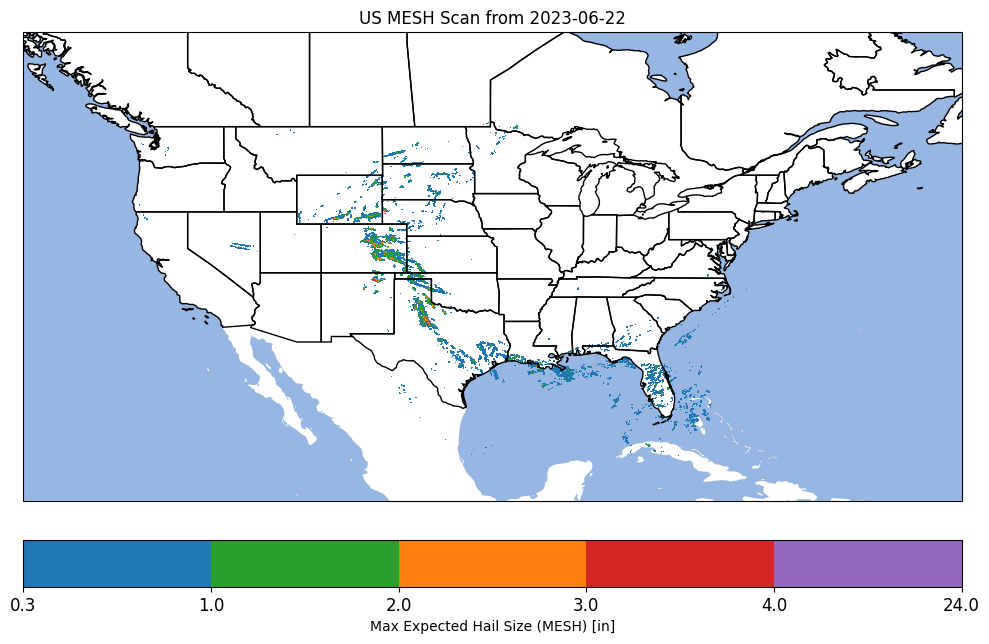

In [23]:
# Generate figure for original, uncropped data
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={
                       "projection": ccrs_projection})

# Optional, adding geographic features helps with map aesthetics
# Add state borders
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor="black")
# Add ocean, lakes features
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

# Get max hail size across all mesh data
max_grib2_mesh = grib2_mesh.max(dim="time")
# Plot the grib2 contours
grib2_contours = plt.contourf(grib2_lon, grib2_lat, max_grib2_mesh,
                            transform=ccrs_projection, cmap=cmap, norm=norm,
                            levels=contour_levels)

# Add color bar for hail
cbar = plt.colorbar(grib2_contours, orientation="horizontal", ax=ax, pad=0.05)
cbar.set_label("Max Expected Hail Size (MESH) [in]")
cbar.ax.tick_params(labelsize=12)
plt.title(f"US MESH Scan from {storm_dt_str}")
plt.tight_layout()
plt.show()

We can now plot the MESH data for the bounding box.

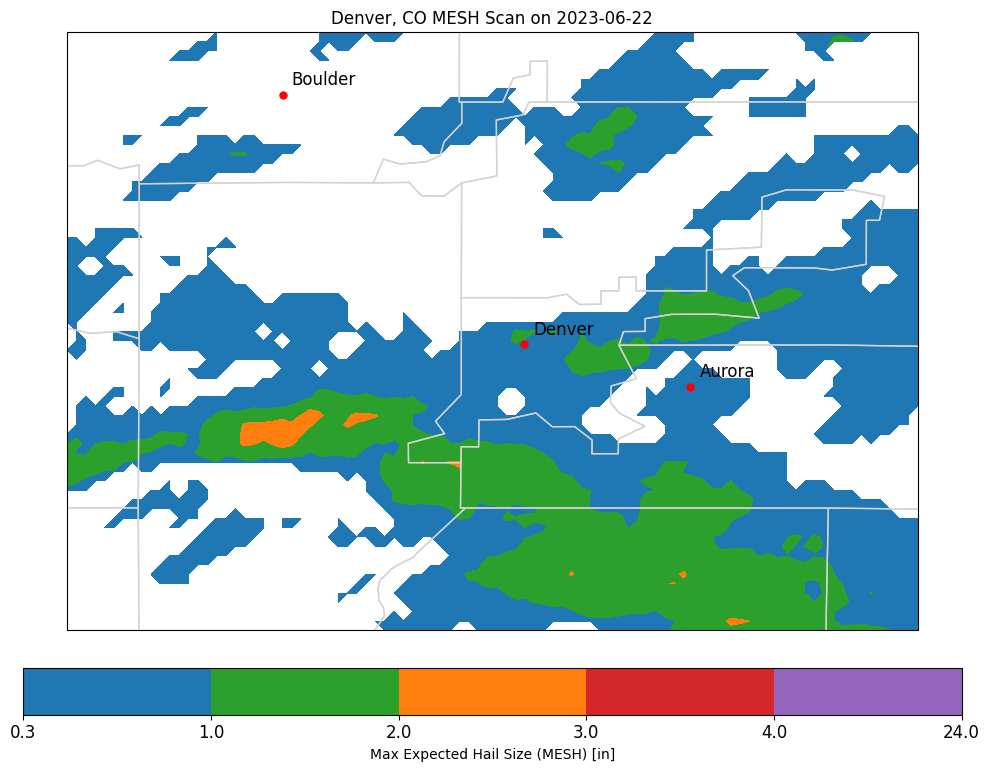

In [25]:
# Generate figure for original, uncropped data
fig2, ax2 = plt.subplots(figsize=(10, 8), subplot_kw={
                       "projection": ccrs_projection})

# Optional, adding geographic features helps with map aesthetics
# Add state borders
ax2.add_feature(cfeature.STATES, linestyle='-', edgecolor="black")
# Add counties
COUNTIES = cfeature.NaturalEarthFeature(
            category="cultural", name="admin_2_counties",
            scale="10m", facecolor="none")
ax2.add_feature(COUNTIES, edgecolor="#D3D3D3")
# Import city names from populated places
shp_filename = shapereader.natural_earth(resolution='10m',
                                                 category='cultural',
                                                 name='populated_places')
reader = shapereader.Reader(shp_filename)
# Plot cities with names
for city in reader.records():
    x, y = city.geometry.x, city.geometry.y
    # Crop city to requested nw, se coordinates so we don't load all cities in the world
    if se_bbox_lat <= y <= nw_bbox_lat:
        if nw_bbox_lon <= x <= se_bbox_lon:
            ax2.plot(x, y, 'ro', markersize=5,
                    transform=ccrs_projection)
            ax2.text(x+0.01, y+0.01,
                    city.attributes['NAME'],
                    fontsize=12,
                    transform=ccrs_projection)
                        
# Get max hail size across all mesh data
max_bbox_mesh = bbox_mesh.max(dim="time")
# Plot the contours
bbox_contours = plt.contourf(bbox_lon, bbox_lat, max_bbox_mesh,
                            transform=ccrs_projection, cmap=cmap, norm=norm,
                            levels=contour_levels)
# Add color bar for hail
cbar = plt.colorbar(bbox_contours, orientation="horizontal", ax=ax2, pad=0.05)
cbar.set_label("Max Expected Hail Size (MESH) [in]")
cbar.ax.tick_params(labelsize=12)
plt.title(f"Denver, CO MESH Scan on {storm_dt_str}")
plt.tight_layout()
plt.show()

## 4) Make Matplotlib Contours into Polygons

Shapely polygons can be created from matplotlib contour path data, which creates the polygons in the matplotlib plot.

In [28]:
# Master poly dict with contour level keys and polygon values
poly_dict = {}
# Get contour paths to make polygons
contour_paths = bbox_contours.get_paths()
for path, level in zip(contour_paths, contour_levels):
    # Add contour level if it does not exist yet
    if level not in poly_dict:
        poly_dict[level] = []
    for poly in path.to_polygons():
        # Make polygons from contour paths
        polygon = Polygon(poly)
        poly_dict[level].append(polygon)

## 5a) Generate KML File from Polygons

With the list of shapely polygons and its associated contour levels and colors, we can put the polygons, their names, and colors into a KML format and save it as a KML file, which can be imported in GIS softwares like Google Earth or ArcGIS Pro. For steps to make the polygons into a GeoJSON format instead, please refer to the next section, "5b) Generate GeoJSON File from Polygons".

In [31]:
# Color map of contours to find colors associated with each contour level
cmap_contour_colors = bbox_contours.get_cmap()

# Initialize kml
kml = Kml()
poly_list = []
poly_contour_level_list = []
for level, polygon in poly_dict.items():
    # Merge overlapping polygons of the same level
    merged_poly = unary_union(polygon)
    # Map hail level to their hail ranges
    if level == 0.3:
        label = "0.3-1"
    elif level == 1:
        label = "1-2"
    elif level == 2:
        label = "2-3"
    elif level == 3:
        label = "3-4"
    elif level == 4:
        label = "4+"
    # Get colors to contours (r,g,b,a)
    rgba = cmap_contour_colors(bbox_contours.norm(level))
    red_color = int(rgba[0]*255)
    blue_color = int(rgba[1]*255)
    green_color = int(rgba[2]*255)
    # Add color to kml file polygons
    style = Style()
    style.polystyle.color = Color.rgb(
        red_color, blue_color, green_color, a=150)
    style.linestyle.color = Color.rgb(
        red_color, blue_color, green_color, a=255)
    style.linestyle.width = 4
    # Add polygons to kml
    if merged_poly.geom_type == 'Polygon':
        kml_poly = kml.newpolygon(name=f"MESH: {label} in")
        kml_poly.outerboundaryis = list(merged_poly.exterior.coords)
        kml_poly.style = style
        # Add polygons to list for later analyses
        poly_list.append(merged_poly)
        poly_contour_level_list.append(level)
    elif merged_poly.geom_type == 'MultiPolygon':
        for poly in merged_poly.geoms:
            kml_poly = kml.newpolygon(name=f"MESH: {label} in")
            kml_poly.outerboundaryis = list(poly.exterior.coords)
            kml_poly.style = style
            # Add polygons to list for later analyses
            poly_list.append(poly)
            poly_contour_level_list.append(level)
            
# Save kml file with specified filename
kml_filename = os.path.join("panel_segmentation", "examples", "mesh_examples", f"Denver_CO_{storm_dt_str}.kml")
kml.save(kml_filename)

## 5b) Generate GeoJSON File from Polygons 

With the list of shapely polygons and its associated contour levels and colors, we can put the polygons, their names, and colors into a GeoJSON format and save it as a GeoJSON file, which can be used in web mapping packages like Folium. For steps to make the polygons into a KML format instead, please refer to the previous section, "5a) Generate KML File from Polygons".

In [34]:
# Create master mesh geojson dictionary
mesh_geojson = {"type":"FeatureCollection", "features": []}
poly_list = []
poly_contour_level_list = []
for index, (level, polygon) in enumerate(poly_dict.items()):
    # Merge overlapping polygons of the same level
    merged_poly = unary_union(polygon)
    # Map hail level to their hail ranges
    if level == 0.3:
        label = "0.3-1"
    elif level == 1:
        label = "1-2"
    elif level == 2:
        label = "2-3"
    elif level == 3:
        label = "3-4"
    elif level == 4:
        label = "4+"
    # Get colors to each contour level
    level_color = contour_colors[index]
    if merged_poly.geom_type == 'Polygon':
        # Add polygons to list for later analyses
        poly_list.append(merged_poly)
        poly_contour_level_list.append(level)
        # Create and add feature polygon to geojson 
        feature = {
            "type": "Feature",
            "properties": {"contour_level": level, 
                           "label": f"MESH: {label} in",
                           "fill_color": level_color},
            "geometry": {
                "type": "Polygon",
                "coordinates": [list(merged_poly.exterior.coords)]
            }}
        mesh_geojson["features"].append(feature)
    elif merged_poly.geom_type == 'MultiPolygon':
        for poly in merged_poly.geoms:
             # Add polygons to list for later analyses
            poly_list.append(poly)
            poly_contour_level_list.append(level)
            # Create and add feature polygon to geojson 
            feature = {
            "type": "Feature",
            "properties": {"contour_level": level, 
                           "label": f"MESH: {label} in",
                           "fill_color": level_color},
            "geometry": {
                "type": "Polygon",
                "coordinates": [list(poly.exterior.coords)]
            }}
            mesh_geojson["features"].append(feature)

geojson_filename = os.path.join("panel_segmentation", "examples", "mesh_examples", f"Denver_CO_{storm_dt_str}.geojson")
# Create geojson file
with open(geojson_filename, "w") as f:
    json.dump(mesh_geojson, f, indent=2)

The following gives an example of how to use Folium to create an interactive html visualization of the MESH scan in GeoJSON format. 

In [36]:
center_lat = (nw_bbox_lat + se_bbox_lat) / 2
center_lon = (nw_bbox_lon + se_bbox_lon) / 2
# Initialize folium map
folium_map = folium.Map(location=(center_lat, center_lon), tiles="Cartodb Positron", zoom_start=10)
# Add satellite layer map
satellite_feature_group = folium.FeatureGroup(name="Satellite", show=False)
satellite_layer = folium.TileLayer(tiles="Esri.WorldImagery",
                                    attr="Esri",
                                    max_zoom=19).add_to(satellite_feature_group)
folium_map.add_child(satellite_feature_group) 
# Add Geojson to Folium map
folium.GeoJson(
        mesh_geojson,
        name="MESH",
        style_function=lambda feature: {
            "fillColor": feature["properties"]["fill_color"],
            "color": feature["properties"]["fill_color"],
            "weight": 0.5, 
        }
    ).add_to(folium_map)
# Create a customized color legend to map color to their hail size ranges
color_legend_html = '''
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     top: 10px; left: 50px; width: 140px; height: 130px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp <b>MESH Ranges [in]</b> <br>
     &nbsp<i class="fa fa-circle" style="color:#1f77b4"></i> 0.3" - 1" &nbsp; <br>
     &nbsp<i class="fa fa-circle" style="color:#2ca02c"></i> 1" - 2" &nbsp;<br>
     &nbsp<i class="fa fa-circle" style="color:#ff7f0e"></i> 2" - 3" &nbsp;<br>
     &nbsp<i class="fa fa-circle" style="color:#d62728"></i> 3" - 4" &nbsp;<br>
     &nbsp<i class="fa fa-circle" style="color:#9467bd"></i> 4"+  &nbsp;<br>
</div>
{% endmacro %}
'''
color_legend = branca.element.MacroElement()
color_legend._template = branca.element.Template(color_legend_html)
folium_map.add_child(color_legend) 

folium.LayerControl().add_to(folium_map)
display(folium_map)



## 6) Calculate Areas for Each Hail Ranges

After the polygons are generated, we can calculate the total area (in mi$^2$) of each hail size ranges.

In [39]:
# Create a result poly_df for the bbox data
poly_df = pd.DataFrame({"contour_level": poly_contour_level_list,
                        "polygon": poly_list})

poly_area_list = []
# Calculate the Area for Each Polygon
for poly in poly_df["polygon"]:
    # Project polygon to get correct area
    geod = Geod(ellps="WGS84")
    poly_area, poly_perimeter = geod.geometry_area_perimeter(poly)
    # Make area positive since it's vector is determined by clockwise or counter-clockwise transversal
    poly_area = abs(poly_area)
    # Make m^2 to mi^2 (since this is the unit we are working with)
    poly_area = poly_area / 2589988.11
    poly_area_list.append(poly_area)
poly_df["area"] = poly_area_list
area_df = poly_df.groupby("contour_level").agg(total_area=("area", "sum")).reset_index()
# Map contour int levels with hail size ranges
contour_hail_map = {
    0.3: "0.3-1",
    1: "1-2",
    2: "2-3",
    3: "3-4",
    4: "4+"}
area_df = area_df.rename(columns={"contour_level": "hail_size_ranges_[in]",
                                  "total_area": "total_area_[mi^2]"})
area_df["hail_size_ranges_[in]"] = area_df["hail_size_ranges_[in]"].map(
    contour_hail_map)
print(area_df.head(10))

  hail_size_ranges_[in]  total_area_[mi^2]
0                 0.3-1         812.048691
1                   1-2         292.282140
2                   2-3           8.630904
